In [1]:
import os
import sys
import shutil
import warnings
import numpy as np
from tqdm import tqdm_notebook
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('..')
warnings.simplefilter('ignore')

from keras.engine.topology import Input
from keras.layers.core import Activation
from keras.layers import Conv2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import (
    TensorBoard, ReduceLROnPlateau,
    LearningRateScheduler, EarlyStopping
)
import keras.backend as K
from keras.regularizers import l2
import tensorflow as tf
import keras

from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

from albumentations import (
    Compose, OneOf, Rotate,
    RandomBrightness, IAAAdditiveGaussianNoise, GaussNoise,
    OpticalDistortion, GridDistortion, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, HueSaturationValue,
    HorizontalFlip, Normalize, RandomGamma, RGBShift,
    Blur, MedianBlur, CLAHE, ToGray, JpegCompression,
    RandomSizedCrop
)

import encoder, decoder
from pooling_layers import MaxPoolingWithArgmax2D, MaxUnpooling2D
from from_torch import transfer_weights
from pascal_voc_data import PascalVocGenerator
from utils import softmax2classes, get_iou, freeze_session

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
height = 256
width = 256
num_classes = len(PascalVocGenerator.classes)
repeat_num = 1
batch_size = 20
epoch_nums = 300

train_aug = Compose([
    OneOf([
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ], p=0.5),
    OneOf([
        GaussNoise(),
        HueSaturationValue(),
        RGBShift()
    ], p=0.5),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        Blur(),
        MedianBlur()
    ], p=0.4),
    OneOf([
        CLAHE(),
        ToGray(),
        JpegCompression()
    ], p=0.2),
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    Normalize(p=1),
])

val_aug = Compose([
    Normalize(p=1)
])

logdir = os.path.join('logs', '{}_epochs_{}_bs_{}x{}'.format(epoch_nums, batch_size, height, width))
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.makedirs(logdir)
os.path.join(os.getcwd()[13:], logdir)

'neural_networks/ENet/logs/300_epochs_20_bs_256x256'

In [3]:
inp = Input(shape=(height, width, 3), name='image')
enet = encoder.build(inp)
enet = decoder.build(enet, nc=num_classes)
enet = Activation('softmax', name='output')(enet)
model = Model(inputs=inp, outputs=enet)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
optim = Adam(lr=0.0005)
model.compile(optimizer=optim, loss=dice_loss, metrics=[iou_score])

In [5]:
for layer in model.layers:
    if isinstance(layer, Conv2D):
        layer.kernel_regularizer = l2(2e-4)

In [6]:
model = transfer_weights(model, weights='model_pretrained.pkl')

Loading pretrained weights from /working_dir/neural_networks/ENet/model_pretrained.pkl


In [3]:
def reduce_lr(epoch, lr):
    if epoch % 100 == 0 and epoch > 0:
        return lr * 0.1
    else:
        return lr

train_generator_aug = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/train70.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), True, train_aug, repeat_num
)
val_generator_aug = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/val30.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), True, val_aug, 1
)

In [ ]:
history = model.fit_generator(
    train_generator_aug, validation_data=val_generator_aug,
    epochs=epoch_nums, verbose=1,
    callbacks=[
        TensorBoard(log_dir=logdir, batch_size=batch_size, write_graph=False),
        LearningRateScheduler(reduce_lr),
#         EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

In [11]:
model.save('300_epochs.h5')

In [4]:
K.set_learning_phase(0)
model = load_model(
    '300_epochs.h5',
    custom_objects={
        'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D(),
        'MaxUnpooling2D': MaxUnpooling2D(),
        'tf': tf,
        'dice_loss': dice_loss
    }
)
model.inputs, model.outputs

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


([<tf.Tensor 'image:0' shape=(?, 256, 256, 3) dtype=float32>],
 [<tf.Tensor 'output/truediv:0' shape=(?, ?, ?, 21) dtype=float32>])

In [5]:
iou = []
for img, true_mask in tqdm_notebook(val_generator_aug):
    pred = model.predict(img)
    for i in range(len(pred)):
        pred_mask = softmax2classes(pred[i])
        iou.append(get_iou(true_mask[i], pred_mask)[0])
    break
np.mean(iou)

0.024370736777426676

0.0127942596478529


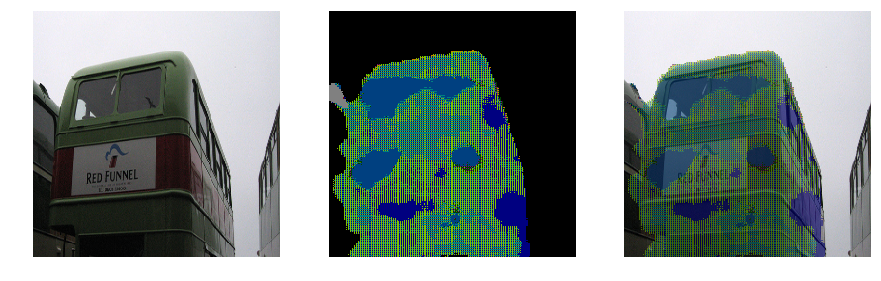

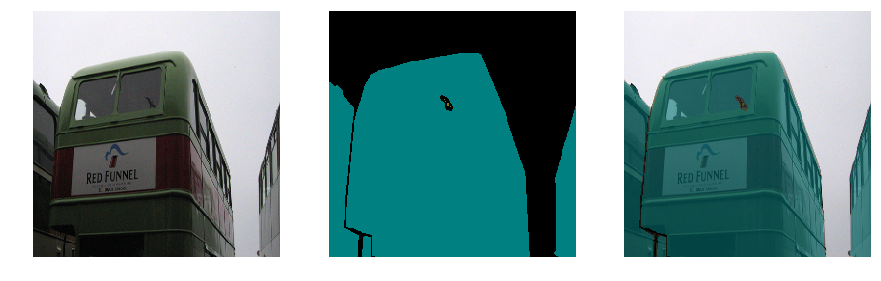

In [6]:
image_num = 10
pred_mask = softmax2classes(pred[image_num])
print(get_iou(true_mask[image_num], pred_mask)[0])
pred_mask_color = train_generator_aug.categorical_to_mask(pred_mask)
true_mask_color = train_generator_aug.categorical_to_mask(true_mask[image_num])
cur_img = (
    (img[image_num] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)) * 255
).astype(np.int)
PascalVocGenerator.segmentation_plot(cur_img, pred_mask_color).show()
PascalVocGenerator.segmentation_plot(cur_img, true_mask_color).show()

In [7]:
freeze_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs], quantize=False)
tf.train.write_graph(freeze_graph, '.', 'ENet_256x256.pb', as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 536 variables.
INFO:tensorflow:Converted 536 variables to const ops.


'./ENet_256x256.pb'

In [5]:
from tensorflow.lite.python.convert import OpsSet
converter = tf.lite.TFLiteConverter.from_frozen_graph(
    'ENet_256x256.pb', input_arrays=['image'],
    output_arrays=['output/truediv'], input_shapes={'image': (1, 256, 256, 3)}
)
converter.allow_custom_ops = True
tflite_model = converter.convert()
open('ENet_256x256.tflite', 'wb').write(tflite_model)

1519212